In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
#import utils
from vqvae import VQVAE

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.distributions import NegativeBinomial
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader, TensorDataset
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

In [2]:
@torch.no_grad()
def generate_clustered_gauss_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,          # 1D latent space
    sigma_val: float = 0.5,       # observation noise std for Gaussian in feature space
    cluster_centers=None,         # if None, auto-generate
    cluster_spread: float = 0.2,  # smaller => tighter clusters in latent space
    seed: int = 42,
    device: str = "cpu",
):
    """
    Build a clean clusterable dataset with 1D latent space:
      z | c ~ N(center[c], cluster_spread^2) in R^latent_dim
      x | z ~ N(W z + b, sigma^2 I) in R^{n_features}
    Returns:
      X [N, D] (float), labels [N] (long), true Z [N, latent_dim], centers [K, latent_dim]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Set cluster centers in latent space (R^{latent_dim})
    if cluster_centers is None:
        # Evenly spaced along the first latent axis; zeros elsewhere if latent_dim>1
        centers_1d = torch.linspace(-2, 2, n_clusters, device=device)
        centers = torch.zeros(n_clusters, latent_dim, device=device)
        centers[:, 0] = centers_1d
    else:
        centers = torch.as_tensor(cluster_centers, dtype=torch.float32, device=device)
        if centers.ndim == 1:
            centers = centers.unsqueeze(1)  # [K,1] if given as list of scalars
        assert centers.shape == (n_clusters, latent_dim), \
            f"centers must be shape ({n_clusters},{latent_dim})"

    # Cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]

    # Latent samples
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]  # shift by cluster centers

    # Linear map to feature space
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    mean_x = z @ W.T + b  # [N, D]

    # Gaussian observation noise (isotropic)
    if sigma_val <= 0:
        X = mean_x
    else:
        X = mean_x + sigma_val * torch.randn(mean_x.shape, device=mean_x.device, generator=g)

    return X, labels.to("cpu"), z.to("cpu"), centers.to("cpu")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Well-separated centers

X, y, Z_true, true_centers = generate_clustered_gauss_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    sigma_val=0.5,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")

Using device: cuda
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


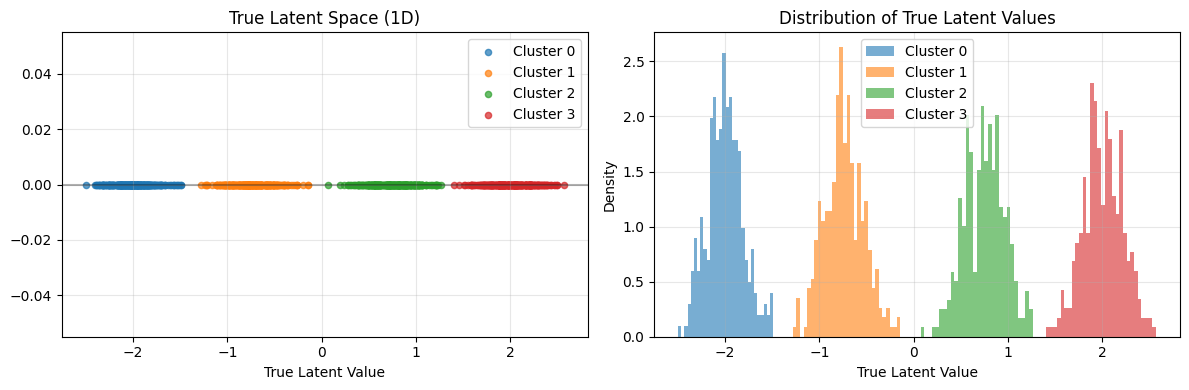

In [4]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)

In [26]:
cluster_centers

[-2.0, -0.75, 0.75, 2.0]

In [45]:
model = VQVAE(
    in_dim=100, x_dim=100, h_dim=64,
    n_layers_enc=2, n_layers_dec=2,
    n_embeddings=4, embedding_dim=1, beta=0.25,
    #embedding_init=np.array(cluster_centers).reshape(4,1),
    trainable_codes=True,
    #out_activation='sigmoid'
).to(device)

In [46]:
next(model.encoder._mlp.parameters()).device

device(type='cuda', index=0)

In [47]:
lr = 1e-4
opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [48]:
epochs = 500

results = {
    'n_updates': 0,
    'recon_loss': [],
    'loss_vals': [],
    'perplexities': [],
}

n_update = 0
for ep in range(1, epochs+1):
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        n_update+=1
        xb = xb.to(device).float()
        opt.zero_grad()
        #losses = fit_step(model, xb, kl_w)
        embedding_loss, x_hat, perplexity = model(xb)
        recon_loss = torch.mean((x_hat - xb)**2)
        loss = recon_loss + embedding_loss
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        results["recon_loss"].append(recon_loss.cpu().detach().numpy())
        results["perplexities"].append(perplexity.cpu().detach().numpy())
        results["loss_vals"].append(loss.cpu().detach().numpy())
        results["n_updates"] = i

        '''
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        '''
        
        tot += loss.item() * xb.size(0)
        n += xb.size(0)
    
    if ep == 1 or ep % 20 == 0 or ep == epochs:
        print(f"[{ep:03d}] loss={tot/n:.3f}")

[001] loss=1.989
[020] loss=1.942
[040] loss=2.630
[060] loss=3.326
[080] loss=2.315
[100] loss=1.606
[120] loss=0.806
[140] loss=0.471
[160] loss=0.346
[180] loss=0.328
[200] loss=0.338
[220] loss=0.356
[240] loss=0.360
[260] loss=0.364
[280] loss=0.370
[300] loss=0.379
[320] loss=0.375
[340] loss=0.372
[360] loss=0.370
[380] loss=0.384
[400] loss=0.384
[420] loss=0.380
[440] loss=0.371
[460] loss=0.379
[480] loss=0.369
[500] loss=0.390


In [49]:
model.vector_quantization.embedding.weight

Parameter containing:
tensor([[ 0.4864],
        [-0.3997],
        [-0.0967],
        [ 0.1877]], device='cuda:0', requires_grad=True)

In [50]:
model.eval()
with torch.no_grad():
    vq_loss, x_hat, perplexity, predicted_clusters = model(X.float().to(device),return_indices=True)
    latent_params = model.encoder(X.float().to(device))

In [40]:
predicted_clusters

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [17]:
next(model.encoder._mlp.parameters()).device

device(type='cuda', index=0)

In [51]:
# Calculate clustering accuracy
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate clustering metrics
ari = adjusted_rand_score(y.numpy(), predicted_clusters.cpu().numpy())
nmi = normalized_mutual_info_score(y.numpy(), predicted_clusters.cpu().numpy())

print(f"Clustering Performance:")
print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  Normalized Mutual Information (NMI): {nmi:.4f}")

# Calculate per-cluster accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y.numpy(), predicted_clusters.cpu().numpy())
print(f"  Confusion Matrix:")
print(cm)


Clustering Performance:
  Adjusted Rand Index (ARI): 0.8192
  Normalized Mutual Information (NMI): 0.8324
  Confusion Matrix:
[[300   0   0   0]
 [ 67   0   1 232]
 [  0  11 281   8]
 [  0 296   4   0]]


In [52]:
enc_mu = latent_params.cpu().numpy()
predicted_clusters = predicted_clusters.cpu().numpy()

In [17]:
latent_params.cpu().numpy()

array([[ 0.4060017 ],
       [ 0.27060276],
       [ 0.64106965],
       ...,
       [-0.54747015],
       [-0.6804499 ],
       [-0.3054393 ]], dtype=float32)

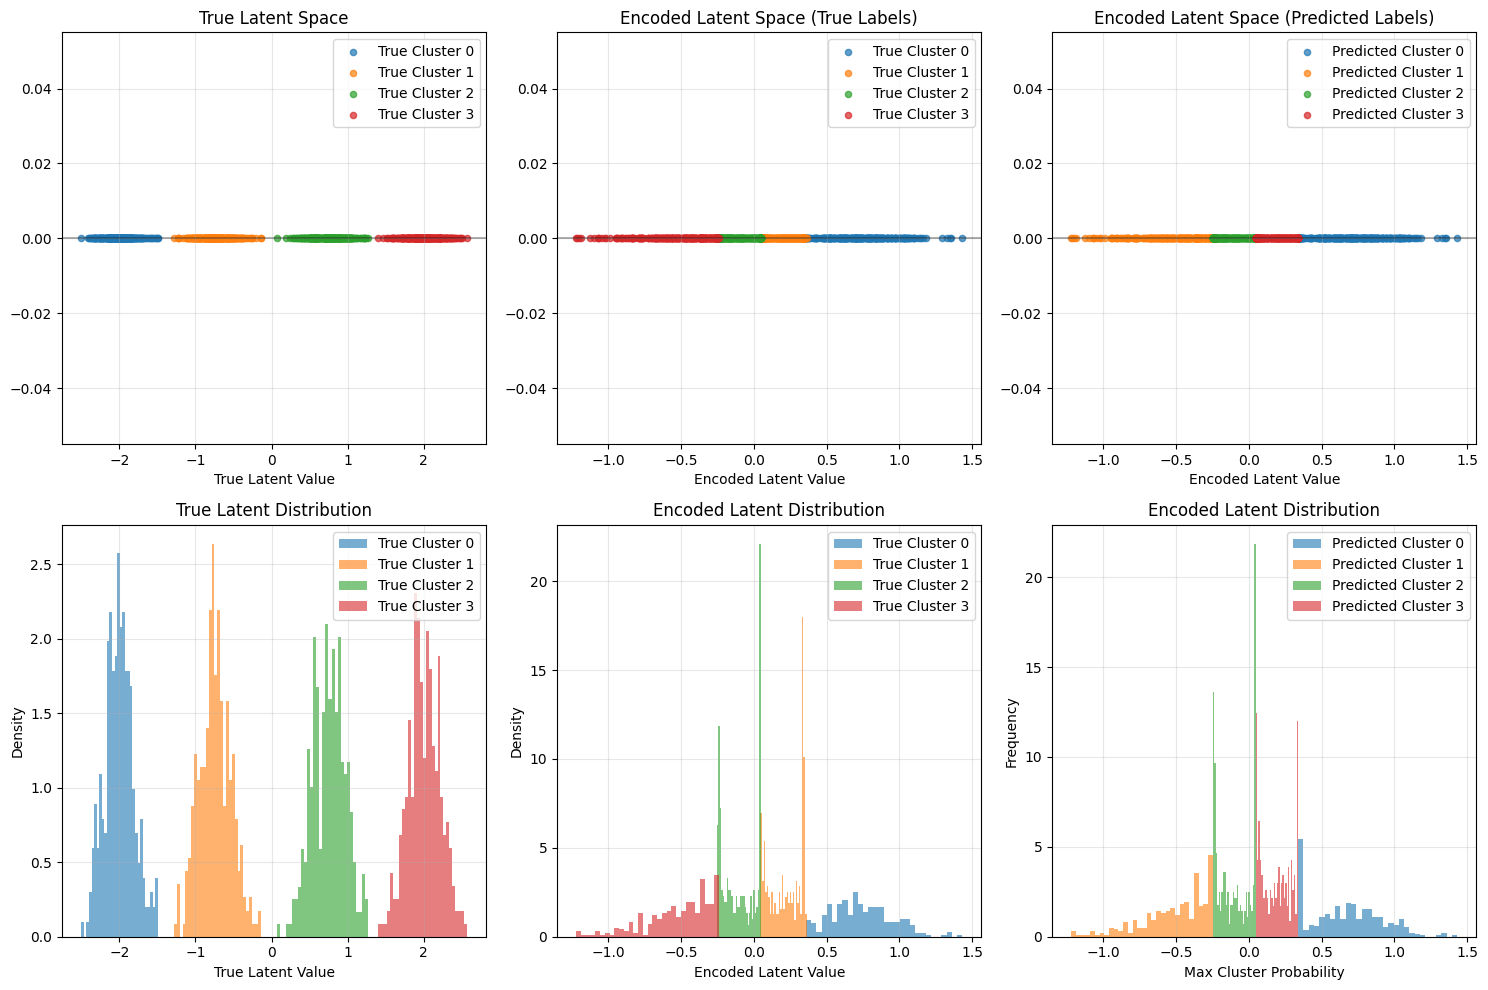

In [53]:
# Visualize results
plt.figure(figsize=(15, 10))

# Plot 1: True vs Predicted latent space
plt.subplot(2, 3, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Encoded latent space colored by true labels
plt.subplot(2, 3, 2)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(enc_mu[mask, 0], np.zeros_like(enc_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Encoded Latent Value')
plt.ylabel('')
plt.title('Encoded Latent Space (True Labels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Encoded latent space colored by predicted labels
plt.subplot(2, 3, 3)
for i in range(n_clusters):
    mask = predicted_clusters == i
    plt.scatter(enc_mu[mask, 0], np.zeros_like(enc_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Predicted Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Encoded Latent Value')
plt.ylabel('')
plt.title('Encoded Latent Space (Predicted Labels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Histogram comparison - True latent
plt.subplot(2, 3, 4)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('True Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Histogram comparison - Encoded latent
plt.subplot(2, 3, 5)
for i in range(n_clusters):
    mask = y == i
    plt.hist(enc_mu[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('Encoded Latent Value')
plt.ylabel('Density')
plt.title('Encoded Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Cluster assignment confidence
plt.subplot(2, 3, 6)
#max_probs = torch.max(cluster_probs, dim=1)[0]
#plt.hist(max_probs.numpy(), bins=30, alpha=0.7, edgecolor='black')
for i in range(n_clusters):
    mask = predicted_clusters == i
    plt.hist(enc_mu[mask, 0], bins=30, alpha=0.6, label=f'Predicted Cluster {i}', density=True)
plt.xlabel('Max Cluster Probability')
plt.ylabel('Frequency')
plt.title('Encoded Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
